CAPM as LINEAR REGRESSION MODEL

ri −rf = αi + βi (rM − rf) + εi 

ri - rf = measure the excess return of the portfolio --> Dependent variable Yi
rM − rf O measure the excess return of the market portfolio --> Explanatory Variable

βi = The parameter that need to be estimated --> (ri - rf) / (rM − rf)

In [2]:

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp

%cd C:\Users\aless\Desktop\LAUREA MAGISTRALE\Time Series Models\CAPM


C:\Users\aless\Desktop\LAUREA MAGISTRALE\Time Series Models\CAPM


ExampleCAPM data:

- The data cover the range from January 1988 to August 2023 on a **monthly** basis

- microsoft will be our full asset allocation of portfolio

- S&P 500 the market portfolio

- Us t-bill our risk free rate return



In [3]:

# Load data
data = pd.read_excel('ExampleCAPM.xlsx', 'CAPM', index_col='DATE', parse_dates=True, na_values=['NA'])


# Time index - monthly
#t = pd.date_range(start='31/01/1988', end='31/08/2023', freq='M')   #associamo i dati all'indice temporale che seguono

# Select data
MSFT = data["MICROSOFT - TOT RETURN IND"]
MKT = data["S&P 500 COMPOSITE - TOT RETURN IND"]
RFREE = data["US TREASURY BILL RATE - 3 MONTH (EP) NADJ"]

# Calcolo dei rendimenti logaritmici (%)
rMSFT = 100 * (np.log(MSFT) - np.log(MSFT.shift(1)))        # 100 * (ln(Pt) - ln(Pt-1))
rMKT = 100 * (np.log(MKT) - np.log(MKT.shift(1)))

# Risk-free mensile (da annuale a mensile)
rF = RFREE / 12

# Rimuovi la prima osservazione (NaN dovuto allo shift)
rMSFT = rMSFT.dropna()
rMKT = rMKT.dropna()
rF = rF.iloc[1:]  # allineo anche risk-free

# Ritorni in eccesso
rMSFTe = rMSFT - rF
rMKTe = rMKT - rF


# Create relevant quantities
mean_rMSFT = rMSFT.mean()


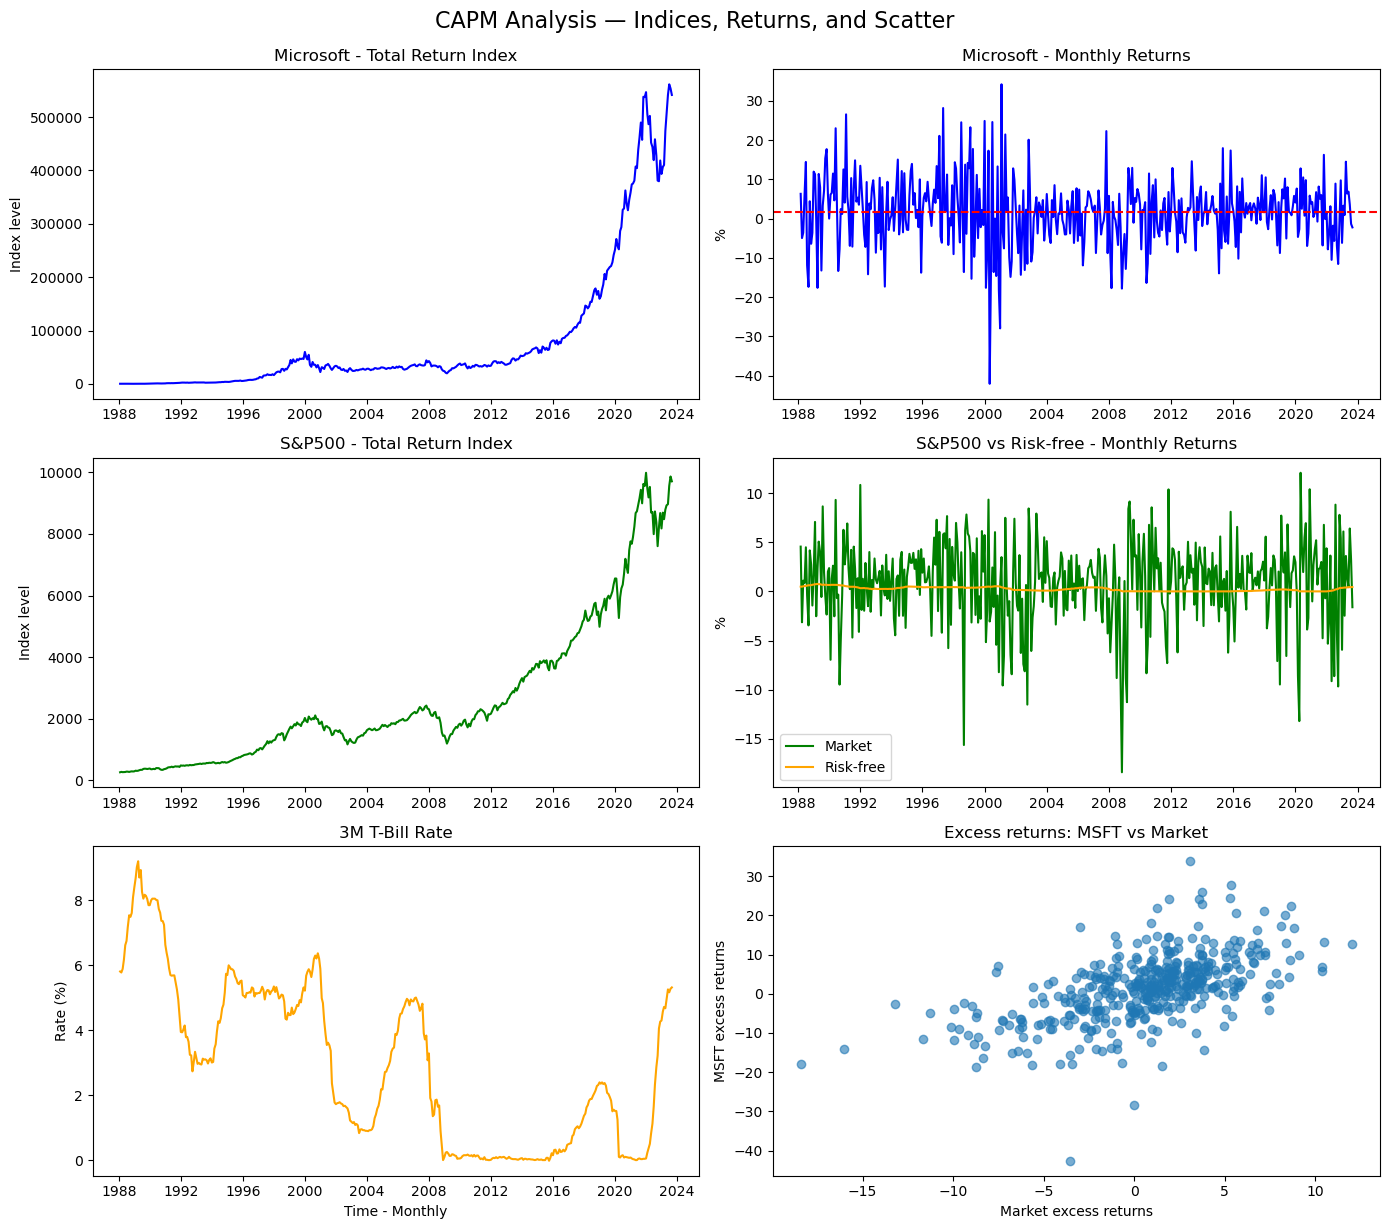

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# -------------------------------
# LIVELLI INDICI
# -------------------------------

# 1. Microsoft index
axs[0,0].plot(MSFT.index, MSFT, color="blue")
axs[0,0].set_title("Microsoft - Total Return Index")
axs[0,0].set_ylabel("Index level")

# 2. S&P500 index
axs[1,0].plot(MKT.index, MKT, color="green")
axs[1,0].set_title("S&P500 - Total Return Index")
axs[1,0].set_ylabel("Index level")

# 3. T-Bill
axs[2,0].plot(RFREE.index, RFREE, color="orange")
axs[2,0].set_title("3M T-Bill Rate")
axs[2,0].set_ylabel("Rate (%)")
axs[2,0].set_xlabel("Time - Monthly")

# -------------------------------
# RENDIMENTI E SCATTER
# -------------------------------

# 4. Microsoft monthly returns
axs[0,1].plot(rMSFT.index, rMSFT, color="blue")
axs[0,1].axhline(y=mean_rMSFT, color="red", linestyle="--", label="Mean")
axs[0,1].set_title("Microsoft - Monthly Returns")
axs[0,1].set_ylabel("%")

# 5. Market vs Risk-free returns
axs[1,1].plot(rMKT.index, rMKT, label="Market", color="green")
axs[1,1].plot(rF.index, rF, label="Risk-free", color="orange")
axs[1,1].set_title("S&P500 vs Risk-free - Monthly Returns")
axs[1,1].set_ylabel("%")
axs[1,1].legend()

# 6. Scatter excess returns
axs[2,1].scatter(rMKTe, rMSFTe, alpha=0.6)
axs[2,1].set_title("Excess returns: MSFT vs Market")
axs[2,1].set_xlabel("Market excess returns")
axs[2,1].set_ylabel("MSFT excess returns")

# -------------------------------
# Layout finale
# -------------------------------
fig.tight_layout()
fig.suptitle("CAPM Analysis — Indices, Returns, and Scatter", fontsize=16, y=1.02)
plt.show()



The AIM now is constructing a straigh line that have the minimum devitation from the observations


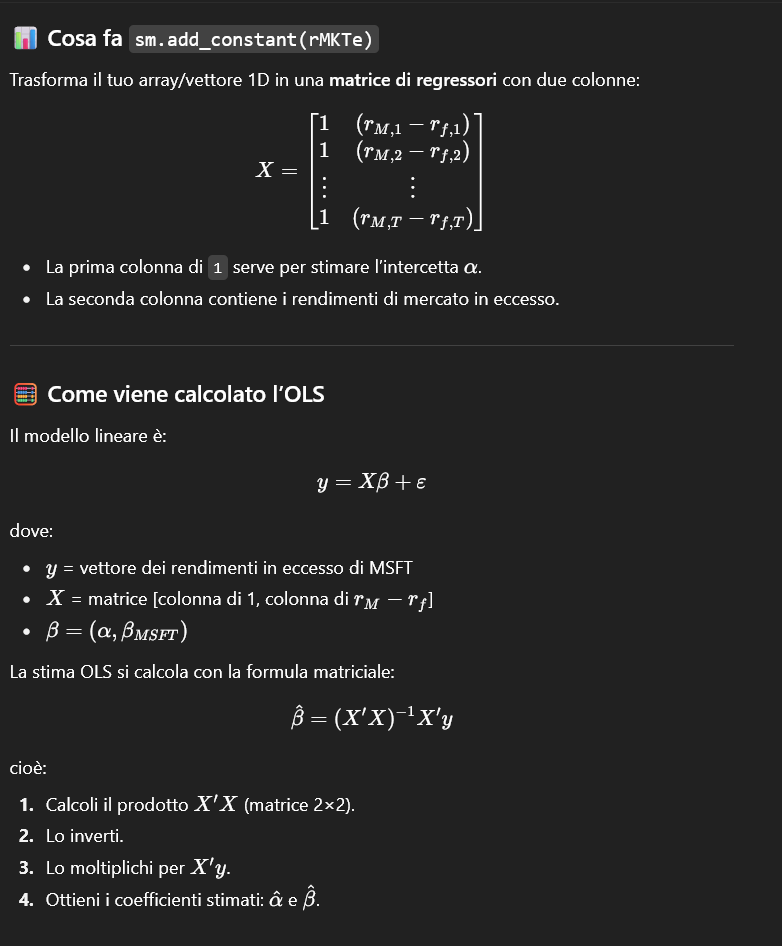

#### Contruction of the regression --> *y=Xβ+ε*


![image.png](attachment:image.png)

Partendo dalla forma matriciale abbiamo due modi per creare il vettore X:

1. Manuale - X = np.column_stack((np.ones_like(rMKTe), rMKTe))

    - np.ones_like(rMKTe) = crea un array di 1 della stessa lunghezza di rMKTe --> array = vettore degli alpha
    - rMKTE = array delle osservazioni Xi, nel nostro caso i rendimenti in eccesso per ogni mese
    - np.column_stack = costruisce la forma matriciale

2. Automatico - X = sm.add_constant(rMKTE)

    - gestisce autonomamente gli array senza dover specificare le variabili

In [6]:

# Running linear regression         excess return MSFT ~ alpha + beta * excess return Market

y = rMSFTe                      # ri - rf
X = sm.add_constant(rMKTe)      # computa la matrice X aggiungendo colonna di 1 per intercetta (alpha) e stima il beta

Res1 = sm.OLS(y, X).fit()
print(Res1.summary())

# Fitted values e residui
fit1 = Res1.fittedvalues   # valori stimati dal modello
resid1 = Res1.resid        # residui (errori = osservato - stimato)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     211.3
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           3.82e-39
Time:                        23:59:25   Log-Likelihood:                -1436.9
No. Observations:                 427   AIC:                             2878.
Df Residuals:                     425   BIC:                             2886.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7438      0.343      2.168      0.0

- const = 0.7438 (α) --> in media Microsoft ha generato ritorni in eccesso per 0.74% al mese indipendenti dal mercato
    - pvalue < 0.05 quindi il dato è significativo

- 0 = 1.1576 (β) --> quando il mercato cresce dell’1% in eccesso rispetto al risk-free, Microsoft cresce in media dell’1.16%.

- R-squared = 0.332 --> Solo il 33% della variabilità dei rendimenti di Microsoft è spiegata dal mercato. LIMITE DEL CAPM

- Durbin-Watson = 2.207 --> Vicino a 2 , i residui non mostrano autocorrelazione seria.

- Jarque-Bera (JB) = 245.923, p≈0.000 --> I residui NON sono normalmente distribuiti → code grasse o outlier.

- Skew = −0.182 → leggera asimmetria negativa.

- Kurtosis = 6.7 → code molto pesanti (valori estremi più frequenti della normale

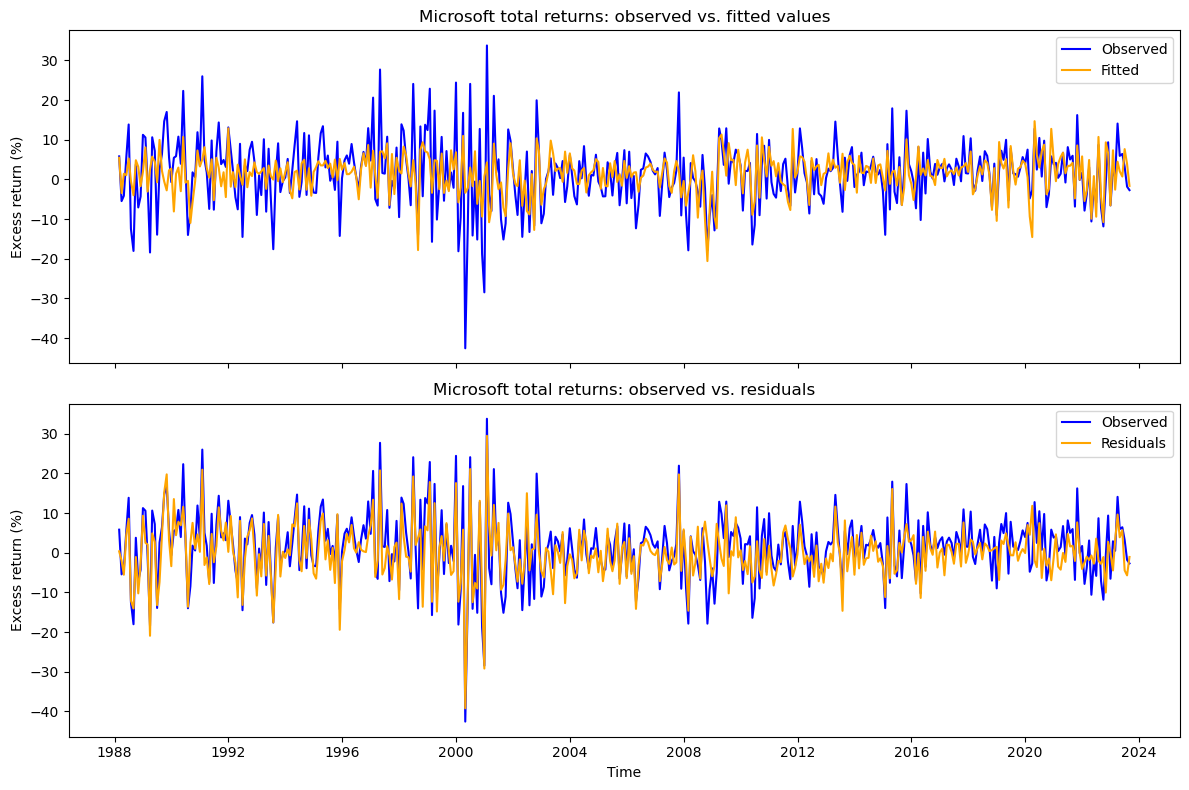

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# 1. Observed vs fitted
axs[0].plot(y.index, y, color="blue", label="Observed")
axs[0].plot(fit1.index, fit1, color="orange", label="Fitted")
axs[0].set_title("Microsoft total returns: observed vs. fitted values")
axs[0].set_ylabel("Excess return (%)")
axs[0].legend()

# 2. Observed vs residuals
axs[1].plot(y.index, y, color="blue", label="Observed")
axs[1].plot(resid1.index, resid1, color="orange", label="Residuals")
axs[1].set_title("Microsoft total returns: observed vs. residuals")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Excess return (%)")
axs[1].legend()

plt.tight_layout()
plt.show()

Possiamo osservare da questi grafici la variabilità spiegata (33%) e non spiegata (67%)

### DIAGNOSTIC ON FUNCTIONAL FORM

Test di Ramsey --> verifichiamo se una regressione ausiliaria avente componenti non lineari stima meglio il modello

Se p-value < 0.05 i coefficenti non lineari sono significativi = Rifiuto H0



In [15]:

# RESET test for linearity
n = np.size(rMKTe)
X = sm.add_constant(rMKTe)
Res1 = sm.OLS(rMSFTe[1:n], X[1:n]).fit()
fit1 = Res1.fittedvalues

# Auxiliary regression
X = np.column_stack((np.ones_like(rMKTe[1:n]), rMKTe[1:n], np.power(fit1, 2), np.power(fit1, 3)))
Res2 = sm.OLS(rMSFTe[1:n], X).fit()

# Test
RSSR = Res1.ssr
RSSU = Res2.ssr
Fstat = ((RSSR - RSSU)/2) / (RSSU/(423))
Pval = 1 - sp.stats.f.cdf(Fstat, 2, 423)
print("RESET test p-value:", Pval)


RESET test p-value: 0.15155030994793317


In [20]:

# CHOW test: single split
n = np.size(rMKTe)
m = 200
X1 = np.column_stack((np.ones_like(rMKTe[1:m]), rMKTe[1:m]))
X2 = np.column_stack((np.ones_like(rMKTe[m+1:n]), rMKTe[m+1:n]))
Res2a = sm.OLS(rMSFTe[1:m], X1).fit()
Res2b = sm.OLS(rMSFTe[m+1:n], X2).fit()
X = sm.add_constant(rMKTe)
Res1 = sm.OLS(rMSFTe[1:n], X[1:n]).fit()

# Recover RSS
RSSU = Res2a.ssr + Res2b.ssr
RSSR = Res1.ssr

# Build test
Fstat = ((RSSR - RSSU)/2) / (RSSU/(n-4))
Pval = 1 - sp.stats.f.cdf(Fstat, 2, n-4)
print("Chow test p-value (single split):", Pval)


Chow test p-value (single split): 0.02071492814861764


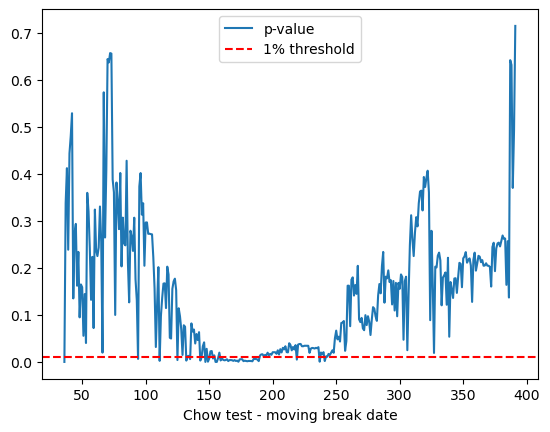

In [11]:

# Chow test with looping across break dates and plot
X = np.column_stack((np.ones_like(rMKTe), rMKTe))
Res1 = sm.OLS(rMSFTe[1:n], X[1:n]).fit()
RSSR = Res1.ssr
w = 36
i1 = w
i2 = n - w
Fstat = np.empty(n-w-w+1, dtype=float)
Pval = np.empty(n-w-w+1, dtype=float)
for ii in range(i1, i2):
    X1 = np.column_stack((np.ones_like(rMKTe[1:ii]), rMKTe[1:ii]))
    X2 = np.column_stack((np.ones_like(rMKTe[ii+1:n]), rMKTe[ii+1:n]))
    Res2a = sm.OLS(rMSFTe[1:ii], X1).fit()
    Res2b = sm.OLS(rMSFTe[ii+1:n], X2).fit()
    RSSU = Res2a.ssr + Res2b.ssr
    Fstat[ii-w+1] = ((RSSR - RSSU)/2) / (RSSU/(n-4))
    Pval[ii-w+1] = 1 - sp.stats.f.cdf(Fstat[ii-w+1], 2, n-4)

plt.plot(range(i1, i2+1), Pval, label='p-value')
plt.axhline(y=0.01, color='r', linestyle='--', label='1% threshold')
plt.xlabel('Chow test - moving break date')
plt.legend()
plt.show()


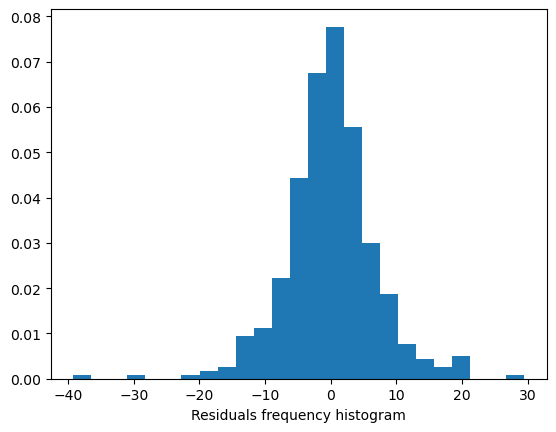

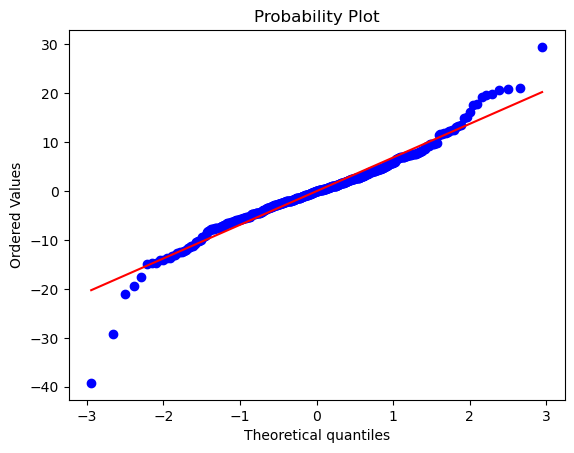

In [ ]:

# Residuals plot
X = np.column_stack((np.ones_like(rMKTe), rMKTe))
Res1 = sm.OLS(rMSFTe[1:n], X[1:n]).fit()
rs = Res1.resid

# Frequency histogram
plt.hist(rs, bins=25, density=True)
plt.xlabel('Residuals frequency histogram')
plt.show()

# Probability plot
sp.stats.probplot(rs, plot=plt)
plt.show()
